In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Draw import rdMolDraw2D

# Part 1: Identify candidates that are most structurally distinct from known antibiotics

In [2]:
# get hits from primary screen and ML screen
df = pd.read_csv('../data/training_plus_ml_curation_hits.csv')
df

,SMILES,Name,hit_inh,hit_kill
0,CCCC[C@H](CC)CNC(=N)N=C(N)NCCCCCCNC(N)=NC(=N)N...,alexidine,1,1
1,NC(Nc1ccc(Cl)cc1)=NC(=N)NCCCCCCNC(=N)N=C(N)Nc1...,chlorhexidine,1,1
2,CC[C@@H](C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([...,polymyxin-B-sulfate,1,1
3,OCCN[C@H]1CCCc2c1[nH]c1ccc(cc21)-c1ccccc1 |&1:...,casin,1,1
4,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,bekanamycin,1,1
...,...,...,...,...
95,CC(=O)O[Pt+4](C)(C)(Cl)(Cl)OC(=O)C.NC1CCCCC1,BRD-M31395033,0,1
96,CN(C)c1ccc(cc1)[C+](c1ccc(cc1)N(C)C)c1ccc(cc1)...,BRD-K60025295,0,1
97,CN1CCN(CC1)c1c(cc2c3c1OCN(C)N3C=C(C(=O)O)C2=O)F,BRD-K71926323,1,1
98,CC(C)c1ccc(cc1)Cn1ccc2c1ccc1nc(nc(c12)N)NC1CC1,BRD-K17140735,1,1


In [3]:
# look at final candidates manually
final_candidates = ['bekanamycin', 'eravacycline', 'LTX-315', 'BAX-channel-blocker', 'semapimod']
finaldf = df[[name in final_candidates for name in list(df['Name'])]]
finaldf

,SMILES,Name,hit_inh,hit_kill
4,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,bekanamycin,1,1
24,CC(=NNC(N)=N)c1cc(NC(=O)CCCCCCCCC(=O)Nc2cc(cc(...,semapimod,1,1
43,NCCCC[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C...,LTX-315,1,1
50,O[C@@H](CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12...,BAX-channel-blocker,1,1
63,[H][C@@]12Cc3c(F)cc(NC(=O)CN4CCCC4)c(O)c3C(=O)...,eravacycline,1,1


In [4]:
# get the fingerprints from the antibiotics curated dataset
df = pd.read_csv('../data/curated_set_of_566_abx.csv')
df['SMILES'] = df['Smiles']
df = df[['Name', 'SMILES']]
not_nans = [type(smi) != float for smi in list(df['SMILES'])]
df = df[not_nans]

smiles = list(df['SMILES'])
names = list(df['Name'])
abx = [Chem.MolFromSmiles(x) for x in smiles]
abx_fps = [Chem.RDKFingerprint(x) for x in abx]

# calculate tanimoto similarity against the set of antibiotics
def compute_highest_tanimoto_against_all_abx(smis):
    mols = [Chem.MolFromSmiles(smi) for smi in smis]
    mols_fp = [Chem.RDKFingerprint(mol) for mol in mols]
    maximums = []
    for mol_fp in mols_fp:
        sims = [DataStructs.FingerprintSimilarity(mol_fp,abx_fp) for abx_fp in abx_fps]
        maximums.append(np.max(sims))
    return(maximums)

# compute TS from these final compounds to antibiotics
maxes = compute_highest_tanimoto_against_all_abx(list(finaldf['SMILES']))
finaldf['max TS to abx'] = maxes
finaldf = finaldf.sort_values('max TS to abx', ascending = True)
finaldf

[16:56:44] WARNING: not removing hydrogen atom without neighbors
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_22170/531951429.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldf['max TS to abx'] = maxes


,SMILES,Name,hit_inh,hit_kill,max TS to abx
24,CC(=NNC(N)=N)c1cc(NC(=O)CCCCCCCCC(=O)Nc2cc(cc(...,semapimod,1,1,0.312606
50,O[C@@H](CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12...,BAX-channel-blocker,1,1,0.386870
63,[H][C@@]12Cc3c(F)cc(NC(=O)CN4CCCC4)c(O)c3C(=O)...,eravacycline,1,1,0.767637
43,NCCCC[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C...,LTX-315,1,1,0.796165
4,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,bekanamycin,1,1,1.000000


# Part 2: Compute tanimoto similarity against all abx

## Makes up the data for a sentence in the results

In [5]:
# compute the tanimoto similarity from one drug to a long list of drugs - specifically all the antibiotics
def compute_tanimoto_against_all_abx(smi):
    mol = Chem.MolFromSmiles(smi)
    mol_fp = Chem.RDKFingerprint(mol)
    sims = [DataStructs.FingerprintSimilarity(mol_fp,abx_fp) for abx_fp in abx_fps]
    
    sim_df = pd.DataFrame()
    sim_df['Tanimoto'] = sims
    sim_df['Abx'] = names
    sim_df = sim_df.sort_values(by = 'Tanimoto', ascending = False)
    return(sim_df)

# compute similarity from semapimod to all antibiotics in this dataset
sema = finaldf[finaldf['Name'] == 'semapimod']
sim_df = compute_tanimoto_against_all_abx(list(sema['SMILES'])[0])
sim_df.to_csv('../out/sema_tanimoto_to_nearest_abx.csv', index = False)
sim_df

,Tanimoto,Abx
227,0.312606,BRILACIDIN
132,0.311306,RETASPIMYCIN
346,0.281654,ERTAPENEM SODIUM
178,0.281654,ERTAPENEM
454,0.281346,POSIZOLID
...,...,...
485,0.032787,PHENOL
503,0.005597,SILVER NITRATE
497,0.001887,IODINE
490,0.000000,SILVER


# Part 3: Plot final molecules for Table 1

semapimod
CC(=NNC(N)=N)c1cc(NC(=O)CCCCCCCCC(=O)Nc2cc(cc(c2)C(C)=NNC(N)=N)C(C)=NNC(N)=N)cc(c1)C(C)=NNC(N)=N


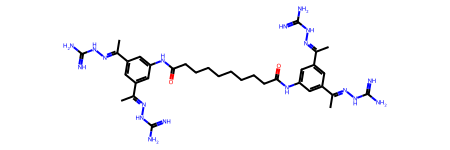

BAX-channel-blocker
O[C@@H](CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12 |&1:1|


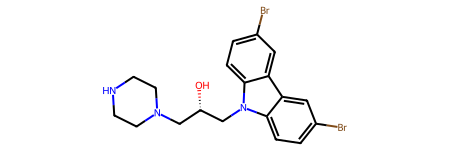

eravacycline
[H][C@@]12Cc3c(F)cc(NC(=O)CN4CCCC4)c(O)c3C(=O)[C@H]1C(=O)[C@]1(O)C(=O)[C@H](C(N)=O)C(=O)[C@@H](N(C)C)[C@]1([H])C2 |&1:29,&2:22|


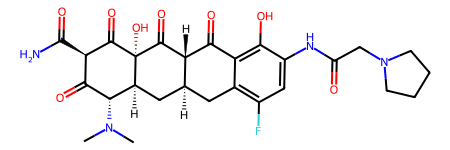

LTX-315
NCCCC[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C(c1ccccc1)c1ccccc1)C(=O)N[C@@H](CCCCN)C(N)=O


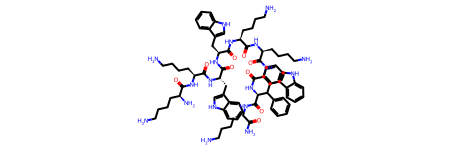

bekanamycin
NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H]2O)[C@H](N)[C@@H](O)[C@@H]1O


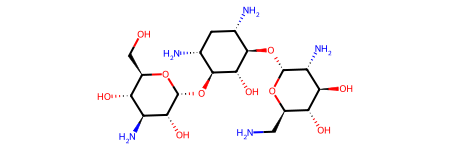

In [6]:
# plot high quality images for each of the final molecules in shortlist
for i, row in finaldf.iterrows():
    # print metadata
    print(row['Name'])
    print(row['SMILES'])

    # get high quality image
    mol = Chem.MolFromSmiles(row['SMILES'])

    # Set up drawing options
    d2d = rdMolDraw2D.MolDraw2DCairo(1500, 1500)  # Set the size of the drawing
    d2d.drawOptions().useBWAtomPalette()
    d2d.drawOptions().flagCloseContactsDist = False

    # Draw the molecule
    d2d.DrawMolecule(mol)

    # Finish drawing
    d2d.FinishDrawing()

    # Save the image
    output_path = '../out/final_cpds/' + row['Name'] + '_chem.png'
    with open(output_path, 'wb+') as f:
        f.write(d2d.GetDrawingText())

    display(Chem.MolFromSmiles(row['SMILES']))